In [1]:
import numpy as np
import quflow as qf
%matplotlib notebook
import matplotlib.pyplot as plt
%config Completer.use_jedi = False

# Simulation of Euler's equations on the sphere

In vorticity formulation, Euler's equations are $$\dot\omega = \{\psi,\omega\} $$ where $\omega$ is the vorticity function and $\psi$ is the stream function (related to $\omega$ via Poisson's equation). The quantized Euler equations are similar $$\dot W = [P,W] $$ but here the vorticity function is relplace by the vorticity matrix $W \in \mathfrak{su}(N)$ and a corresponding stream matrix $P\in\mathfrak{su}(N)$.

## Create initial conditions

In [2]:
N = 128 # Size of matrices

In [3]:
W0 = qf.shr2mat(qf.as_shr(qf.load("W_0.mat")), N=N)
print(W0.shape)

(128, 128)


<IPython.core.display.Javascript object>


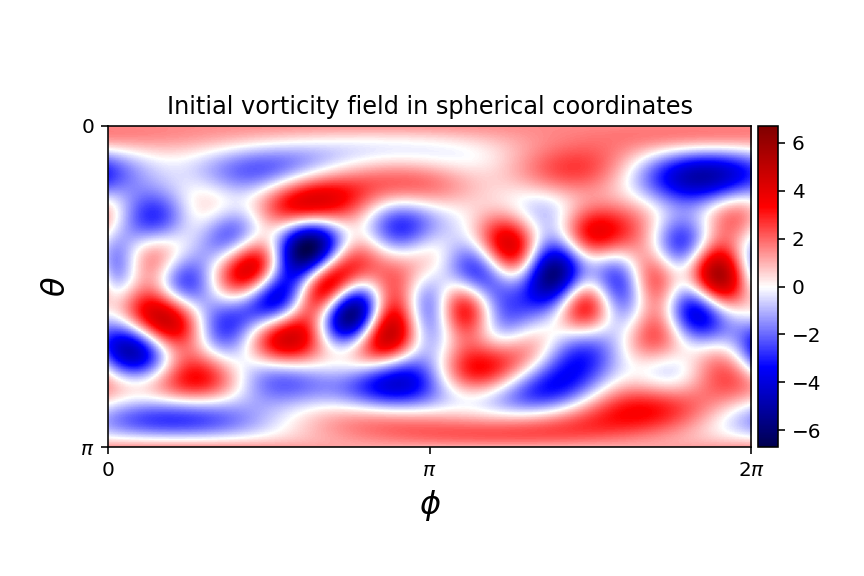

In [30]:
ax = qf.plot(W0) # Display initial vorticity using spherical coordinates
ax.axes.set_title('Initial vorticity field in spherical coordinates');

## Run simulation and animate the results

<IPython.core.display.Javascript object>


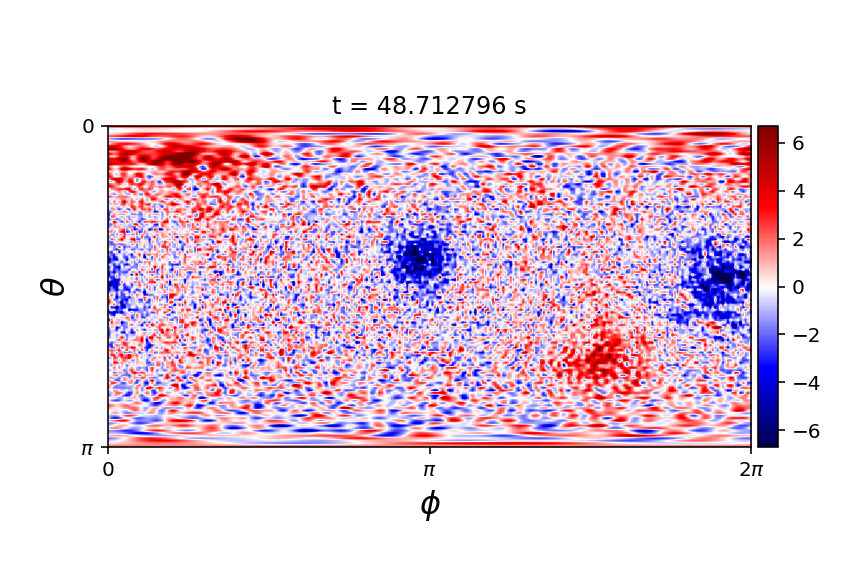

In [28]:
from matplotlib.animation import FuncAnimation

W = W0.copy()
img_ax = qf.plot(W)
h = 0.5 # Stepsize in qtime units
steps_per_frame = 100

def animate(frame_num):
    qf.heun(W, stepsize=h, steps=steps_per_frame)
    img_ax.set_array(qf.as_fun(W))
    img_ax.axes.set_title("t = %f s"%(qf.qtime2seconds(h*steps_per_frame*frame_num, N)))
    return ax

anim = FuncAnimation(img_ax.figure, animate, frames=200, interval=20, repeat=False)
plt.show()